# AI in Industry project
# Flare prediction
- Ildebrando Simeoni - ildebrando.simeoni@studio.unibo.it
- Davide Femia - davide.femia@studio.unibo.it
- Riccardo Falco - riccardo.falco2@tudio.unibo.it
- Vincenzo Collura - vincenzo.collura2@studio.unibo.it


## Libraries

In [1]:
%load_ext autoreload
%autoreload 2

from Libs.load_data import DataLoader, get_dataset_split
import Libs.flares_plot as fplt
from Libs.threshold import get_labels_physic, get_labels_KDE, get_labels_quantile, get_labels_quantile_on_run
from Libs.keras_f1score import f1_m
from Libs.config import models_data_folder

import numpy as np
import pandas as pd
import os
from itertools import product
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, auc, roc_curve

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.initializers import Constant

2023-03-19 09:33:40.590913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 09:33:40.736431: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-19 09:33:40.736456: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-19 09:33:41.867208: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Dataframe building

In [2]:
data_loader = DataLoader(run=100, N=1000, s=0.5, t=0.01, d=0.2, m=1, override=False, folder=models_data_folder)
params = data_loader.get_params()
params

{'run': 100,
 'sigma': [0.5],
 'theta': [0.01],
 'mu': [1],
 'delta': [0.2],
 'N': 1000}

In [3]:
Xs, best_labels = data_loader.get_grid()

In [4]:
dataset_split_params = {
    'window_size': 20, # how large is the window
    'overlap_size': 19, # how many time interval of overlap there is between the windows
    'label_treshold': 1, # how many labels have to be at 1 in the window_size to consider the current window as a flare
    'split_on_run': True, # if True the windows of a run cannot be on different sets
    'shuffle_run': False, # if True shuffles the order of the runs before computing the windows
    'shuffle_window': False, # if True shuffles the order of the windows in the resulting dataframes
    'test_size': 0.3, # size of the test set expressed in percentage
    'val_size': 0.2, # size of the validation set expressed in percentage, considered only if get_validation is True
    'get_validation': True, # if True the output would be train,val,test set, otherwise it would be train,test
    'random_state': 42 # sets the seed for reproducibility
}
df_train, df_val, df_test = get_dataset_split(Xs, best_labels, **dataset_split_params)
df_train

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,future_flare
0,1.000000,0.975000,0.798931,0.583646,0.464899,0.415264,0.454590,0.359812,0.359033,0.382212,...,0.351799,0.391335,0.446848,0.293677,0.298714,0.280781,0.209521,0.256383,0.307991,0
1,0.975000,0.798931,0.583646,0.464899,0.415264,0.454590,0.359812,0.359033,0.382212,0.344712,...,0.391335,0.446848,0.293677,0.298714,0.280781,0.209521,0.256383,0.307991,0.228228,0
2,0.798931,0.583646,0.464899,0.415264,0.454590,0.359812,0.359033,0.382212,0.344712,0.351799,...,0.446848,0.293677,0.298714,0.280781,0.209521,0.256383,0.307991,0.228228,0.187999,0
3,0.583646,0.464899,0.415264,0.454590,0.359812,0.359033,0.382212,0.344712,0.351799,0.391335,...,0.293677,0.298714,0.280781,0.209521,0.256383,0.307991,0.228228,0.187999,0.145653,0
4,0.464899,0.415264,0.454590,0.359812,0.359033,0.382212,0.344712,0.351799,0.391335,0.446848,...,0.298714,0.280781,0.209521,0.256383,0.307991,0.228228,0.187999,0.145653,0.135238,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48015,0.100721,0.133561,0.153607,0.256644,0.301407,0.250394,0.237981,0.261486,0.303675,0.336200,...,0.207898,0.159825,0.155198,0.197111,0.189724,0.124323,0.201641,0.252559,0.395413,0
48016,0.133561,0.153607,0.256644,0.301407,0.250394,0.237981,0.261486,0.303675,0.336200,0.207536,...,0.159825,0.155198,0.197111,0.189724,0.124323,0.201641,0.252559,0.395413,0.315961,0
48017,0.153607,0.256644,0.301407,0.250394,0.237981,0.261486,0.303675,0.336200,0.207536,0.207898,...,0.155198,0.197111,0.189724,0.124323,0.201641,0.252559,0.395413,0.315961,0.345996,0
48018,0.256644,0.301407,0.250394,0.237981,0.261486,0.303675,0.336200,0.207536,0.207898,0.159825,...,0.197111,0.189724,0.124323,0.201641,0.252559,0.395413,0.315961,0.345996,0.371824,0


In [5]:
df_val

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,future_flare
0,1.000000,0.975000,1.049886,0.709235,0.775284,0.808206,1.002916,0.784006,0.784185,0.811902,...,0.564956,0.422026,0.396772,0.345643,0.431470,0.431736,0.357961,0.559436,0.549288,0
1,0.975000,1.049886,0.709235,0.775284,0.808206,1.002916,0.784006,0.784185,0.811902,0.552614,...,0.422026,0.396772,0.345643,0.431470,0.431736,0.357961,0.559436,0.549288,0.444852,0
2,1.049886,0.709235,0.775284,0.808206,1.002916,0.784006,0.784185,0.811902,0.552614,0.564956,...,0.396772,0.345643,0.431470,0.431736,0.357961,0.559436,0.549288,0.444852,0.560786,0
3,0.709235,0.775284,0.808206,1.002916,0.784006,0.784185,0.811902,0.552614,0.564956,0.422026,...,0.345643,0.431470,0.431736,0.357961,0.559436,0.549288,0.444852,0.560786,0.640663,0
4,0.775284,0.808206,1.002916,0.784006,0.784185,0.811902,0.552614,0.564956,0.422026,0.396772,...,0.431470,0.431736,0.357961,0.559436,0.549288,0.444852,0.560786,0.640663,0.652257,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20575,0.052285,0.048019,0.071015,0.049237,0.052889,0.051587,0.057016,0.064530,0.066676,0.086608,...,0.094474,0.180342,0.265600,0.236947,0.265520,0.262787,0.237580,0.318366,0.250948,0
20576,0.048019,0.071015,0.049237,0.052889,0.051587,0.057016,0.064530,0.066676,0.086608,0.094120,...,0.180342,0.265600,0.236947,0.265520,0.262787,0.237580,0.318366,0.250948,0.151192,0
20577,0.071015,0.049237,0.052889,0.051587,0.057016,0.064530,0.066676,0.086608,0.094120,0.094474,...,0.265600,0.236947,0.265520,0.262787,0.237580,0.318366,0.250948,0.151192,0.119847,0
20578,0.049237,0.052889,0.051587,0.057016,0.064530,0.066676,0.086608,0.094120,0.094474,0.180342,...,0.236947,0.265520,0.262787,0.237580,0.318366,0.250948,0.151192,0.119847,0.097869,0


In [6]:
df_test

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,future_flare
0,1.000000,0.975000,0.956607,0.750944,0.504365,0.388350,0.361403,0.293419,0.347587,0.360320,...,0.503110,0.571377,0.571170,0.347337,0.337584,0.211312,0.207977,0.233514,0.319375,0
1,0.975000,0.956607,0.750944,0.504365,0.388350,0.361403,0.293419,0.347587,0.360320,0.462558,...,0.571377,0.571170,0.347337,0.337584,0.211312,0.207977,0.233514,0.319375,0.198887,0
2,0.956607,0.750944,0.504365,0.388350,0.361403,0.293419,0.347587,0.360320,0.462558,0.503110,...,0.571170,0.347337,0.337584,0.211312,0.207977,0.233514,0.319375,0.198887,0.159106,0
3,0.750944,0.504365,0.388350,0.361403,0.293419,0.347587,0.360320,0.462558,0.503110,0.571377,...,0.347337,0.337584,0.211312,0.207977,0.233514,0.319375,0.198887,0.159106,0.110544,0
4,0.504365,0.388350,0.361403,0.293419,0.347587,0.360320,0.462558,0.503110,0.571377,0.571170,...,0.337584,0.211312,0.207977,0.233514,0.319375,0.198887,0.159106,0.110544,0.124472,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29395,0.088472,0.079050,0.127112,0.124727,0.123249,0.134629,0.152770,0.194376,0.148435,0.154884,...,0.224690,0.133206,0.122031,0.089321,0.082637,0.110813,0.104113,0.176562,0.172137,0
29396,0.079050,0.127112,0.124727,0.123249,0.134629,0.152770,0.194376,0.148435,0.154884,0.235067,...,0.133206,0.122031,0.089321,0.082637,0.110813,0.104113,0.176562,0.172137,0.148510,0
29397,0.127112,0.124727,0.123249,0.134629,0.152770,0.194376,0.148435,0.154884,0.235067,0.224690,...,0.122031,0.089321,0.082637,0.110813,0.104113,0.176562,0.172137,0.148510,0.165008,0
29398,0.124727,0.123249,0.134629,0.152770,0.194376,0.148435,0.154884,0.235067,0.224690,0.133206,...,0.089321,0.082637,0.110813,0.104113,0.176562,0.172137,0.148510,0.165008,0.277899,0


In [7]:
# number of classes
print('Training set:')
train_counts = df_train['future_flare'].value_counts()
print(train_counts, '\n')
print('validation set:')
val_counts = df_val['future_flare'].value_counts()
print(val_counts, '\n')
print('Test set:')
test_counts = df_test['future_flare'].value_counts()
print(test_counts, '\n')
print('Total:')
total_counts = train_counts.add(val_counts).add(test_counts)
print(total_counts, '\n')


Training set:
0    42573
1     5447
Name: future_flare, dtype: int64 

validation set:
0    18776
1     1804
Name: future_flare, dtype: int64 

Test set:
0    26320
1     3080
Name: future_flare, dtype: int64 

Total:
0    87669
1    10331
Name: future_flare, dtype: int64 



In [8]:
X_train, y_train = df_train.iloc[:,:-1].to_numpy(), df_train.future_flare.to_numpy()
X_val, y_val = df_val.iloc[:,:-1].to_numpy(), df_val.future_flare.to_numpy()
X_test, y_test = df_test.iloc[:,:-1].to_numpy(), df_test.future_flare.to_numpy()
X_train_val, y_train_val = np.vstack((X_train, X_val)), np.hstack((y_train, y_val))
X, y = np.vstack((X_train, X_val, X_test)), np.hstack((y_train, y_val, y_test))
print('X ## Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape, 'Total', X.shape)
print('y ## Train:', y_train.shape, '   Val:', y_val.shape, '   Test:', y_test.shape, '   Total', y.shape)

X ## Train: (48020, 20) Val: (20580, 20) Test: (29400, 20) Total (98000, 20)
y ## Train: (48020,)     Val: (20580,)     Test: (29400,)     Total (98000,)


## Models

### Crossvalidation of simple models

In [9]:
model_lbls = ['dt', 'nb', 'lp', 'svc', 'knn']

class_weights = {0:1, 1:5}

# Set the parameters to be explored by the grid for each classifier
tuned_param_dt = [{'max_depth': list(range(1,20))}]
tuned_param_nb = [{'var_smoothing': [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-07, 1e-8, 1e-9, 1e-10]}]
tuned_param_lp = [{'early_stopping': [True]}]
tuned_param_svc = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000], 'class_weight':[class_weights]},
                   
                   
                   {'kernel': ['linear'], 'C': [1, 10, 100, 1000], 'class_weight':[class_weights]}]
tuned_param_knn =[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]


# set the models to be fitted specifying name, estimator and parameter structure
models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(), 
           'param': tuned_param_dt,
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': tuned_param_nb
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(),
           'param': tuned_param_lp,
          },
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(), 
           'param': tuned_param_svc
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': tuned_param_knn
          }
}

# scores to be explored
scores = ['f1_macro']

In [10]:
def print_results(model):
    print("Best parameters set found on train_val set:")
    print()
    # if best is linear there is no gamma parameter
    print(model.best_params_)
    print()
    print("Grid scores on train_val set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, std, params_tuple in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params_tuple))
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    print("The model is trained on the full train_val set.")
    print("The scores are computed on the full test set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    print('AUC:', auc(fpr, tpr))
    print()

In [11]:
results_short = {}
cv_results = []
models_override = False
for score in scores:
    print('='*40)
    print("# Tuning hyper-parameters for %s" % score)
    print()
    s_result = []
    for m in model_lbls:
        print('-'*40)
        print("Trying model {}".format(models[m]['name']))
        model_path = os.path.join("models", f"{score}_{m}.pkl")
        if (not os.path.exists(model_path)) or models_override:
            clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv=5,
                               scoring='%s' % score,
                               return_train_score = False,
                               n_jobs = 2, # this allows using multi-cores
                               )
            clf.fit(X_train_val, y_train_val)
            joblib.dump(clf, model_path)
        else:
            clf = joblib.load(model_path)
        print_results(clf)
        s_result.append(clf)
        results_short[m] = clf.best_score_
    cv_results.append(s_result)
    print("Summary of results for {}".format(score))
    print("Estimator")
    for m in results_short.keys():
        print("{}\t - score: {:5.2f}%".format(models[m]['name'], results_short[m]*100))

# Tuning hyper-parameters for f1_macro

----------------------------------------
Trying model Decision Tree       
Best parameters set found on train_val set:

{'max_depth': 17}

Grid scores on train_val set:

0.915 (+/-0.026) for {'max_depth': 1}
0.938 (+/-0.020) for {'max_depth': 2}
0.956 (+/-0.018) for {'max_depth': 3}
0.966 (+/-0.015) for {'max_depth': 4}
0.971 (+/-0.015) for {'max_depth': 5}
0.977 (+/-0.012) for {'max_depth': 6}
0.980 (+/-0.011) for {'max_depth': 7}
0.982 (+/-0.009) for {'max_depth': 8}
0.984 (+/-0.009) for {'max_depth': 9}
0.985 (+/-0.007) for {'max_depth': 10}
0.986 (+/-0.007) for {'max_depth': 11}
0.986 (+/-0.007) for {'max_depth': 12}
0.986 (+/-0.005) for {'max_depth': 13}
0.986 (+/-0.006) for {'max_depth': 14}
0.986 (+/-0.005) for {'max_depth': 15}
0.986 (+/-0.006) for {'max_depth': 16}
0.986 (+/-0.005) for {'max_depth': 17}
0.986 (+/-0.006) for {'max_depth': 18}
0.986 (+/-0.006) for {'max_depth': 19}

Detailed classification report for the best parameter set

### CNN

In [12]:
# Standardize Data
scaler = StandardScaler()
scaler.fit(X)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)
X_test_std = scaler.transform(X_test)
# Make the data uniform to multivariate timeseries
X_train_std = X_train_std.reshape((X_train_std.shape[0], X_train_std.shape[1], 1))
X_val_std = X_val_std.reshape((X_val_std.shape[0], X_val_std.shape[1], 1))
X_test_std = X_test_std.reshape((X_test_std.shape[0], X_test_std.shape[1], 1))
# get automatically the number of classes
num_classes = len(np.unique(y))

In [13]:
def make_model(input_shape, num_classes, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    if num_classes==2:
        output_layer = keras.layers.Dense(1, activation="sigmoid", bias_initializer=output_bias)(gap)
    else:
        output_layer = keras.layers.Dense(num_classes, activation="softmax", bias_initializer=output_bias)(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

initial_bias = np.log([train_counts[1]/train_counts[0]])
cnn_model = make_model(input_shape=X_train_std.shape[1:], num_classes=num_classes, output_bias=initial_bias)
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 batch_normalization (BatchN  (None, 20, 64)           256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 20, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 64)            12352     
                                                                 
 batch_normalization_1 (Batc  (None, 20, 64)           256       
 hNormalization)                                             

2023-03-19 09:33:53.595090: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-19 09:33:53.595150: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-19 09:33:53.595177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5166cf34c918): /proc/driver/nvidia/version does not exist
2023-03-19 09:33:53.595489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 25,793
Trainable params: 25,409
Non-trainable params: 384
_________________________________________________________________


In [14]:
cnn_path = os.path.join("models", "CNN_best_weights.h5")

override_cnn = False
if override_cnn:
    epochs = 500
    batch_size = 256
    callbacks = [
        keras.callbacks.ModelCheckpoint(cnn_path, save_weights_only=True, monitor="val_loss"),
        keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=20, min_lr=0.0001),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1)
    ]
    if num_classes==2:
        loss = keras.losses.BinaryCrossentropy()
    else:
        loss = "sparse_categorical_crossentropy"
    cnn_model.compile(
        optimizer="adam",
        loss=loss,
        metrics=[f1_m],
    )
    cnn_history = cnn_model.fit(
        X_train_std,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=(X_val_std, y_val),
        verbose=1,
    )

Epoch 1/500
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
188/188 [==============================] - 10s 39ms/step - loss: 0.0759 - f1_m: 0.8625 - val_loss: 0.1937 - val_f1_m: 0.0496 - lr: 0.0010
Epoch 2/500
188/188 [==============================] - 7s 37ms/step - loss: 0.0486 - f1_m: 0.9088 - val_loss: 0.1588 - val_f1_m: 0.0849 - lr: 0.0010
Epoch 3/500
188/188 [==============================] - 8s 40ms/step - loss: 0.0400 - f1_m: 0.9268 - val_loss: 0.0832 - val_f1_m: 0.1869 - lr: 0.0010
Epoch 4/500
188/188 [==============================] - 10s 56ms/step - loss: 0.0364 - f1_m: 0.9353 - val_loss: 0.0712 - val_f1_m: 0.2171 - lr: 0.0010
Epoch 5/500
188/188 [==============================] - 7s 37ms/step - loss: 0.0374 - f1_m: 0.9312 - val_loss: 0.0544 - val_f1_m: 0.2791 - lr: 0.0010
Epoch 6/500
188/188 [==============================]

188/188 [==============================] - 7s 40ms/step - loss: 0.0146 - f1_m: 0.9722 - val_loss: 0.0560 - val_f1_m: 0.3644 - lr: 0.0010
Epoch 53/500
188/188 [==============================] - 9s 46ms/step - loss: 0.0148 - f1_m: 0.9727 - val_loss: 0.0401 - val_f1_m: 0.2901 - lr: 0.0010
Epoch 54/500
188/188 [==============================] - 7s 39ms/step - loss: 0.0135 - f1_m: 0.9759 - val_loss: 0.0446 - val_f1_m: 0.2912 - lr: 0.0010
Epoch 55/500
188/188 [==============================] - 7s 36ms/step - loss: 0.0139 - f1_m: 0.9767 - val_loss: 0.0373 - val_f1_m: 0.2956 - lr: 0.0010
Epoch 56/500
188/188 [==============================] - 7s 35ms/step - loss: 0.0167 - f1_m: 0.9704 - val_loss: 0.0810 - val_f1_m: 0.3521 - lr: 0.0010
Epoch 57/500
188/188 [==============================] - 7s 36ms/step - loss: 0.0134 - f1_m: 0.9762 - val_loss: 0.0181 - val_f1_m: 0.3424 - lr: 0.0010
Epoch 58/500
188/188 [==============================] - 7s 35ms/step - loss: 0.0132 - f1_m: 0.9787 - val_loss: 0.

Epoch 107/500
188/188 [==============================] - 8s 43ms/step - loss: 0.0099 - f1_m: 0.9841 - val_loss: 0.0203 - val_f1_m: 0.3442 - lr: 0.0010
Epoch 108/500
188/188 [==============================] - 7s 40ms/step - loss: 0.0102 - f1_m: 0.9833 - val_loss: 0.0310 - val_f1_m: 0.3122 - lr: 0.0010
Epoch 109/500
188/188 [==============================] - 8s 42ms/step - loss: 0.0127 - f1_m: 0.9772 - val_loss: 0.0353 - val_f1_m: 0.3026 - lr: 0.0010
Epoch 110/500
188/188 [==============================] - 7s 35ms/step - loss: 0.0101 - f1_m: 0.9832 - val_loss: 0.0388 - val_f1_m: 0.2923 - lr: 0.0010
Epoch 111/500
188/188 [==============================] - 7s 36ms/step - loss: 0.0107 - f1_m: 0.9831 - val_loss: 0.0187 - val_f1_m: 0.3334 - lr: 0.0010
Epoch 112/500
188/188 [==============================] - 7s 35ms/step - loss: 0.0086 - f1_m: 0.9868 - val_loss: 0.0178 - val_f1_m: 0.3698 - lr: 0.0010
Epoch 113/500
188/188 [==============================] - 7s 38ms/step - loss: 0.0109 - f1_m: 0

188/188 [==============================] - 7s 36ms/step - loss: 0.0063 - f1_m: 0.9899 - val_loss: 0.0381 - val_f1_m: 0.3131 - lr: 5.0000e-04
Epoch 161/500
188/188 [==============================] - 7s 35ms/step - loss: 0.0066 - f1_m: 0.9898 - val_loss: 0.0379 - val_f1_m: 0.3240 - lr: 5.0000e-04
Epoch 162/500
188/188 [==============================] - 7s 35ms/step - loss: 0.0072 - f1_m: 0.9882 - val_loss: 0.0828 - val_f1_m: 0.2701 - lr: 5.0000e-04
Epoch 163/500
188/188 [==============================] - 8s 41ms/step - loss: 0.0069 - f1_m: 0.9889 - val_loss: 0.0601 - val_f1_m: 0.2828 - lr: 5.0000e-04
Epoch 164/500
188/188 [==============================] - 8s 42ms/step - loss: 0.0068 - f1_m: 0.9892 - val_loss: 0.1580 - val_f1_m: 0.2689 - lr: 5.0000e-04
Epoch 165/500
188/188 [==============================] - 8s 42ms/step - loss: 0.0066 - f1_m: 0.9883 - val_loss: 0.0786 - val_f1_m: 0.2704 - lr: 5.0000e-04
Epoch 166/500
188/188 [==============================] - 7s 39ms/step - loss: 0.0098

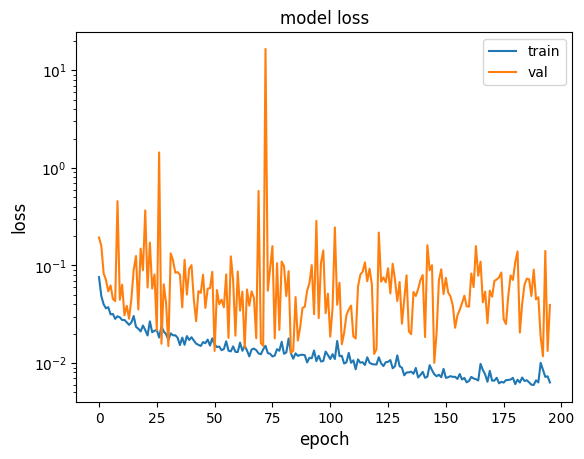

In [17]:
if override_cnn:
    metric = "loss"
    plt.figure()
    plt.plot(cnn_history.history[metric])
    plt.plot(cnn_history.history["val_" + metric])
    plt.title("model " + metric)
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val"], loc="best")
    plt.yscale('log')
    plt.show()
    plt.close()

In [19]:
cnn_model = make_model(input_shape=X_train_std.shape[1:], num_classes=num_classes)
cnn_model.load_weights(cnn_path)
y_test_pred_cnn = np.round(cnn_model.predict(X_test_std), 0)
test_f1_macro_cnn = f1_score(y_test, y_test_pred_cnn, average='macro')
print("Test F1 Macro", test_f1_macro_cnn)

fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_test_pred_cnn, pos_label=1)
print('AUC:', auc(fpr_cnn, tpr_cnn))

919/919 [==============================] - 3s 3ms/step
Test F1 Macro 0.9586331742217953
AUC: 0.9305194805194805


### LSTM

In [20]:
# define model
def make_lstm(input_shape, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    lstm_model = Sequential()
    lstm_model.add(Bidirectional(LSTM(20, activation='relu'), input_shape=input_shape))
    lstm_model.add(Dense(30, activation='relu'))
    lstm_model.add(Dense(10, activation='relu'))
    lstm_model.add(Dense(1, activation='sigmoid',bias_initializer=output_bias))
    return lstm_model

initial_bias = np.log([train_counts[1]/train_counts[0]])
lstm_model = make_lstm((X_train_std.shape[1], 1), output_bias=initial_bias)
lstm_model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[f1_m, 'accuracy'])

print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 40)               3520      
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 30)                1230      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 5,071
Trainable params: 5,071
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
lstm_path = os.path.join("models", "LSTM_best_weights.h5")
override_lstm = False

if override_lstm:
    epochs = 20
    batch_size = 32
    # define callbacks
    callbacks = [
        ModelCheckpoint(lstm_path, save_weights_only=True, monitor="val_loss"),
        EarlyStopping(monitor="val_loss", patience=3, verbose=1),
    ]
    # fit model
    lstm_history = lstm_model.fit(
        X_train_std,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=(X_val_std, y_val),
        verbose=1,
    )

Epoch 1/20
1501/1501 [==============================] - 27s 16ms/step - loss: 0.0471 - f1_m: 0.8646 - accuracy: 0.9814 - val_loss: 0.0232 - val_f1_m: 0.1197 - val_accuracy: 0.9925
Epoch 2/20
1501/1501 [==============================] - 19s 13ms/step - loss: 0.0282 - f1_m: 0.9220 - accuracy: 0.9898 - val_loss: 0.0233 - val_f1_m: 0.1166 - val_accuracy: 0.9926
Epoch 3/20
1501/1501 [==============================] - 22s 14ms/step - loss: 0.0214 - f1_m: 0.9350 - accuracy: 0.9915 - val_loss: 0.0172 - val_f1_m: 0.1216 - val_accuracy: 0.9941
Epoch 4/20
1501/1501 [==============================] - 20s 13ms/step - loss: 0.0200 - f1_m: 0.9416 - accuracy: 0.9924 - val_loss: 0.0220 - val_f1_m: 0.1165 - val_accuracy: 0.9907
Epoch 5/20
1501/1501 [==============================] - 23s 15ms/step - loss: 0.5266 - f1_m: 0.9317 - accuracy: 0.9916 - val_loss: 0.0233 - val_f1_m: 0.1134 - val_accuracy: 0.9914
Epoch 6/20
1501/1501 [==============================] - 22s 15ms/step - loss: 0.0207 - f1_m: 0.9401 

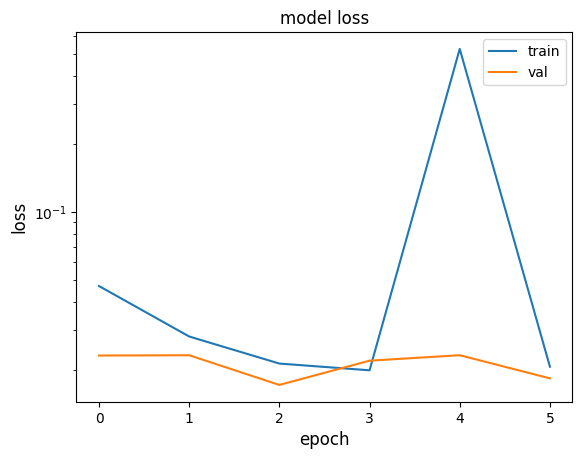

In [22]:
if override_lstm:
    metric = "loss"
    plt.figure()
    plt.plot(lstm_history.history[metric])
    plt.plot(lstm_history.history["val_" + metric])
    plt.title("model " + metric)
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val"], loc="best")
    plt.yscale('log')
    plt.show()
    plt.close()

In [24]:
lstm_model = make_lstm((X_train_std.shape[1], 1))
lstm_model.load_weights(lstm_path)
y_test_pred_lstm = np.round(lstm_model.predict(X_test_std), 0)

print("### Evaluation on test set ###")
print("F1 Macro score: %.2f" % (f1_score(y_test, y_test_pred_lstm, average='macro')))
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_test_pred_lstm)
print(result)

fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_test_pred_lstm, pos_label=1)
print('AUC:', auc(fpr_lstm, tpr_lstm))


919/919 [==============================] - 4s 4ms/step
### Evaluation on test set ###
F1 Macro score: 0.98
[[26276    44]
 [  178  2902]]
AUC: 0.9702680298424978
